In [1]:
from pylab import *
import numpy as np
import matplotlib, pylab
from dcll.npamlib import plotLIF
from dcll.pytorch_libdcll import *
import os.path as path

matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['savefig.dpi']=400.
matplotlib.rcParams['font.size']=14.0
matplotlib.rcParams['figure.figsize']=(5.0,3.5)
matplotlib.rcParams['axes.formatter.limits']=[-10,10]
matplotlib.rcParams['axes.labelsize']= 14.
matplotlib.rcParams['figure.subplot.bottom'] = .2
matplotlib.rcParams['figure.subplot.left'] = .2       

In [2]:
# all_layers_folder_id = range(1, 5, 1)
all_layers_folder_id = [1]
base_folder = "../Paper_results_long/{:03d}__09-10-2018"
base_folder_begin = "../Paper_results/{:03d}__09-10-2018"
all_layers_folders = [
    base_folder.format(n) for n in all_layers_folder_id
]
all_layers_begin_folders = [
    base_folder_begin.format(n) for n in all_layers_folder_id
]
print(list(all_layers_folder_id))

[1]


In [14]:
import pickle
    
def plot_accuracy(directories, n_updates_tick=1, comment="", discard_last_epoch=0, vline=None, xmax=None, n_layers=None):
    args = np.load(path.join(directories[0],"args.pkl"))
    batch_size = args['batch_size']
    n_test_interval = args['n_test_interval']
 
    acc_test = [ np.load(path.join(d, "acc_test.npy")) for d in directories ]
    acc_test = np.array(acc_test)
    
    acc_test_ref = [ np.load(path.join(d, "acc_test_ref.npy")) for d in directories ]
    acc_test_ref = np.array(acc_test_ref)
    
    if discard_last_epoch > 0:
        acc_test = acc_test[:, :-discard_last_epoch]
        acc_test_ref = acc_test_ref[:, :-discard_last_epoch]
    
    print("Acc test last layer last epoch: {}".format(acc_test[0,-1,:,2]))
    print("(n_runs, n_epoch/test_interval, n_batch_test, n_layers): {}".format(acc_test.shape))
    n_epoch = (acc_test.shape[1] - 1) * n_test_interval + 1
    if n_layers is None:
        n_layers = acc_test.shape[3]
    
    parameters = pickle.load(open(path.join(directories[0], 'parameters_0.pkl'), 'rb'))
    n_weights = 0
    n_bias = 0
    for k, v in parameters.items():
        if k.endswith('.i2h.weight'):
            n_weights += v.size
        elif k.endswith('.i2h.bias'):
            n_bias +=v.size            
    print("number of trained weights: {} bias: {}".format(n_weights, n_bias))
    print("number of test samples: {}".format(acc_test.shape[2] * batch_size))

    print(acc_test[0, 15, 1, 2])
    test_epochs = np.arange(0, n_epoch, n_test_interval, dtype='int') + 1
    # mean over the multiple test batches
    weighted_acc = np.mean(acc_test, axis=2)
    weighted_acc_ref = np.mean(acc_test_ref, axis=2)
    # mean over the multiple runs with different seeds
    mean_acc = np.mean(weighted_acc, axis=0)
    std_acc = np.std(weighted_acc, axis=0)
    mean_acc_ref = np.mean(weighted_acc_ref, axis=0)
    std_acc_ref = np.std(weighted_acc_ref, axis=0)
    
    print("Accuracy: {}".format(mean_acc[:, -1]))
    print("Accuracy ref: {}".format(mean_acc_ref))
    
    fig = figure()
    ax = subplot(111)
    x = test_epochs*batch_size//n_updates_tick
    
    for l in range(n_layers):
        ax.plot(x, 1-mean_acc[:,l],
                linewidth=3,
                alpha=.75, label = 'Layer {}'.format(l+1))
        ax.fill_between(x, 1-mean_acc[:,l] - std_acc[:,l], 1-mean_acc[:,l] + std_acc[:,l],
                       alpha=.2)
    ax.plot(x, 1-mean_acc_ref,
                linewidth=3, linestyle='--',
                alpha=.75, label = 'Reference')
    ax.fill_between(x, 1-mean_acc_ref - std_acc_ref, 1-mean_acc_ref + std_acc_ref,
                alpha=.2)
    

        
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.grid()
    legend()
    ax.set_ylabel('Error[%]')
    ax.set_xlabel('Training Samples [{}]'.format(n_updates_tick))
    tight_layout()
    ax.set_ylim([0,0.6])
    ax.set_xlim(0, n_epoch*batch_size // n_updates_tick)
    #ax.set_xlim(batch_size, 40000)
    if vline is not None:
        ax.axvline(x=vline, linestyle=':', color='black')  
    [prev_xmin, prev_xmax] = ax.get_xlim()
    if xmax is not None:
        ax.set_xlim(prev_xmin, xmax)
    savefig(path.join(path.dirname(directories[0]), 'convergence_mnist{}.png'.format(comment)), dpi=300, frameon=False)

# Accuracy of the network

Acc test last layer last epoch: [1.       1.       1.       0.96875  0.96875  0.953125 0.984375 0.96875
 0.984375 0.90625  0.953125 0.953125 0.984375 0.96875  0.96875  0.953125]
(n_runs, n_epoch/test_interval, n_batch_test, n_layers): (1, 29, 16, 4)
number of trained weights: 75664 bias: 136
number of test samples: 1024
0.984375
Accuracy: [0.11816406 0.87890625 0.91796875 0.93164062 0.94140625 0.95410156
 0.95019531 0.9453125  0.95410156 0.95996094 0.96191406 0.95898438
 0.95800781 0.95800781 0.95898438 0.94921875 0.96582031 0.95507812
 0.96289062 0.95800781 0.95605469 0.95507812 0.96386719 0.96679688
 0.96679688 0.96972656 0.9609375  0.96582031 0.96777344]
Accuracy ref: [0.10546875 0.765625   0.85449219 0.890625   0.91894531 0.93066406
 0.93652344 0.93457031 0.94335938 0.95117188 0.95703125 0.95703125
 0.96191406 0.9609375  0.9609375  0.95996094 0.96777344 0.96191406
 0.96582031 0.96875    0.95703125 0.96582031 0.97167969 0.96875
 0.97167969 0.97265625 0.97265625 0.97070312 0.97949219

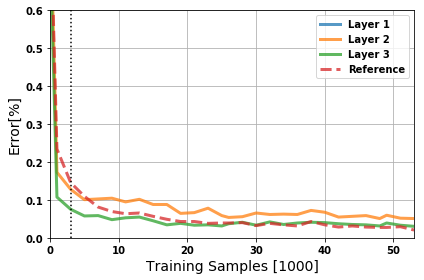

In [15]:
n_updates_tick = 1000
vline = 3000 / 1000
plot_accuracy(all_layers_folders, n_updates_tick=n_updates_tick, discard_last_epoch=2, vline=vline, n_layers=3)

# Accuracy of the network at the beginning

Acc test last layer last epoch: [0.953125 0.953125 0.984375 0.890625 0.953125 0.90625  0.90625  0.84375
 0.890625 0.859375 0.859375 0.90625  0.953125 0.9375   0.875    0.90625 ]
(n_runs, n_epoch/test_interval, n_batch_test, n_layers): (1, 50, 16, 4)
number of trained weights: 75664 bias: 136
number of test samples: 1024
0.796875
Accuracy: [0.11035156 0.5078125  0.54492188 0.63574219 0.67480469 0.72265625
 0.74609375 0.80859375 0.77929688 0.82421875 0.81738281 0.79003906
 0.83398438 0.82324219 0.80761719 0.8359375  0.81445312 0.86132812
 0.85351562 0.87890625 0.875      0.87792969 0.84667969 0.88183594
 0.84667969 0.88671875 0.8828125  0.89550781 0.87597656 0.88574219
 0.88769531 0.89941406 0.88183594 0.89550781 0.88964844 0.89257812
 0.90234375 0.89941406 0.90332031 0.88769531 0.89550781 0.89453125
 0.91113281 0.90527344 0.8984375  0.90917969 0.88867188 0.91015625
 0.90332031 0.90429688]
Accuracy ref: [0.10546875 0.10546875 0.10546875 0.10546875 0.08886719 0.18554688
 0.16992188 0.1328

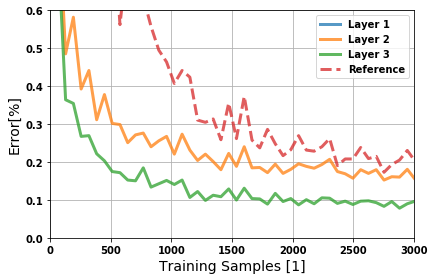

In [16]:
plot_accuracy(all_layers_begin_folders, comment="_begin", xmax=3000, n_layers=3)

In [9]:
acc_test

array([[[[0.078125, 0.3125  , 0.359375],
         [0.078125, 0.3125  , 0.359375],
         [0.078125, 0.3125  , 0.359375],
         ...,
         [0.078125, 0.3125  , 0.359375],
         [0.078125, 0.3125  , 0.359375],
         [0.078125, 0.3125  , 0.359375]],

        [[0.0625  , 0.5625  , 0.78125 ],
         [0.0625  , 0.5625  , 0.78125 ],
         [0.0625  , 0.5625  , 0.78125 ],
         ...,
         [0.0625  , 0.5625  , 0.796875],
         [0.0625  , 0.5625  , 0.796875],
         [0.0625  , 0.5625  , 0.796875]],

        [[0.140625, 0.53125 , 0.90625 ],
         [0.140625, 0.53125 , 0.90625 ],
         [0.140625, 0.53125 , 0.90625 ],
         ...,
         [0.140625, 0.53125 , 0.90625 ],
         [0.140625, 0.53125 , 0.90625 ],
         [0.140625, 0.53125 , 0.90625 ]],

        ...,

        [[0.15625 , 0.9375  , 1.      ],
         [0.15625 , 0.9375  , 1.      ],
         [0.15625 , 0.9375  , 1.      ],
         ...,
         [0.15625 , 0.9375  , 1.      ],
         [0.15625 , 0.

In [10]:
acc_test.shape

(10, 30, 24, 3)

In [12]:
np.mean(acc_test, axis=2).shape

(10, 30, 3)

In [27]:
all_layers_folders[0]

'../Paper_results/001__01-10-2018'